[I 2025-01-22 05:39:21,438] A new study created in memory with name: no-name-586e34b6-ce93-4a6e-aaa3-aaa956dad4e8


전처리 완료: X shape=(1655, 2, 55), y shape=(1655,)
SMOTE 적용 완료: X_resampled shape=(2500, 2, 55), y_resampled shape=(2500,)


[I 2025-01-22 05:39:35,767] Trial 0 finished with value: 0.9927999973297119 and parameters: {'units': 200, 'filters': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0009058477611303367}. Best is trial 0 with value: 0.9927999973297119.
[I 2025-01-22 05:39:48,851] Trial 1 finished with value: 0.9927999973297119 and parameters: {'units': 150, 'filters': 96, 'dropout_rate': 0.4, 'learning_rate': 0.009106874617365158}. Best is trial 0 with value: 0.9927999973297119.
[I 2025-01-22 05:40:06,099] Trial 2 finished with value: 0.977999997138977 and parameters: {'units': 150, 'filters': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00019863774375348254}. Best is trial 0 with value: 0.9927999973297119.
[I 2025-01-22 05:40:23,153] Trial 3 finished with value: 0.9940000057220459 and parameters: {'units': 150, 'filters': 96, 'dropout_rate': 0.4, 'learning_rate': 0.005876819608325533}. Best is trial 3 with value: 0.9940000057220459.
[I 2025-01-22 05:40:37,320] Trial 4 finish

최적 하이퍼파라미터: {'units': 100, 'filters': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001081199287092612}
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5924 - loss: 0.6688 - val_accuracy: 0.8900 - val_loss: 0.4250 - learning_rate: 0.0011
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8171 - loss: 0.4338 - val_accuracy: 0.9275 - val_loss: 0.2581 - learning_rate: 0.0011
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9224 - loss: 0.2531 - val_accuracy: 0.9500 - val_loss: 0.1864 - learning_rate: 0.0011
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9474 - loss: 0.1948 - val_accuracy: 0.9775 - val_loss: 0.1196 - learning_rate: 0.0011
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9644 - loss: 0.1234 - val_accuracy: 0.9775 - val_loss: 0.0976 - learning_rate: 0.0011
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9747 - loss: 0.0947 - val_accuracy: 0.9775 - val_loss: 0.0831 - le

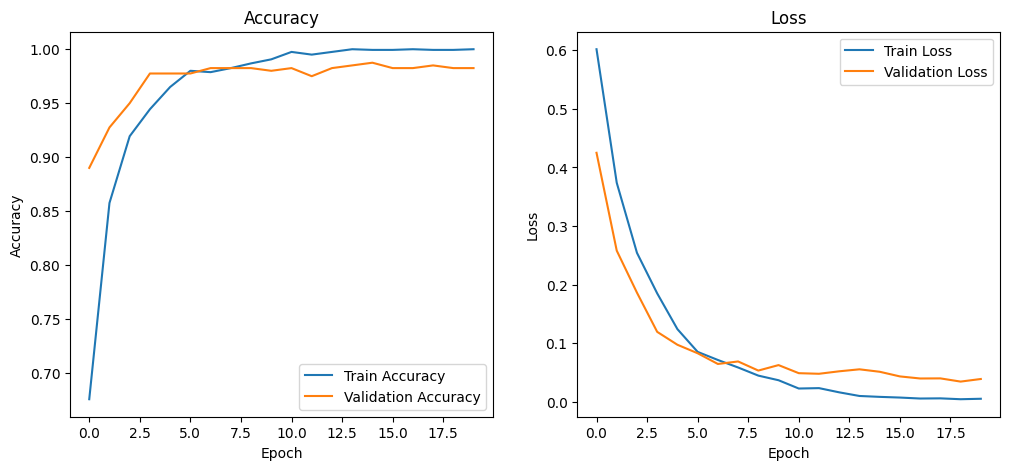

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


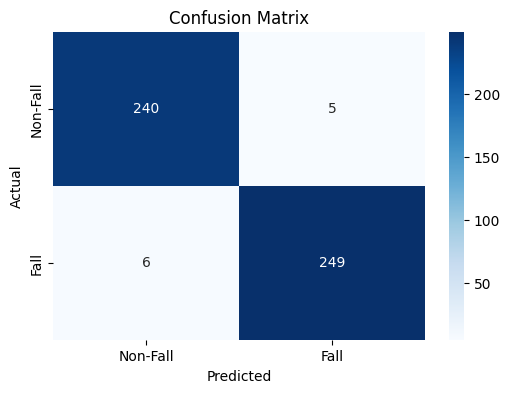

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# 데이터 전처리 함수
def preprocess_without_subject(file_path, timesteps=3):
    df = pd.read_csv(file_path)
    df = df.sort_values(by=['status', 'interval'])  # status와 interval 기준으로 정렬

    features = [col for col in df.columns if col not in ['subject', 'status', 'interval', 'label']]
    label_col = 'label'

    X, y = [], []

    grouped = df.groupby('status')  # status별로 데이터 그룹화

    for _, group in grouped:
        feature_data = group[features].values
        label_data = group[label_col].values

        scaler = StandardScaler()
        feature_data = scaler.fit_transform(feature_data)

        if len(feature_data) < timesteps:
            continue

        for i in range(len(feature_data) - timesteps + 1):
            X.append(feature_data[i:i + timesteps])
            y.append(label_data[i + timesteps - 1])

    return np.array(X), np.array(y)

# 데이터 전처리
file_path = r"D:\deep_learning\preprocessed_cleaned_data.csv"
timesteps = 3
X, y = preprocess_without_subject(file_path, timesteps=timesteps)
print(f"전처리 완료: X shape={X.shape}, y shape={y.shape}")

# SMOTE 데이터 증강
X_flatten = X.reshape(X.shape[0], -1)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flatten, y)
X_resampled = X_resampled.reshape(X_resampled.shape[0], timesteps, -1)
print(f"SMOTE 적용 완료: X_resampled shape={X_resampled.shape}, y_resampled shape={y_resampled.shape}")

# Stratified K-Fold 교차 검증
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델 정의 함수
def create_lstm_cnn_model(units=150, filters=96, dropout_rate=0.3, learning_rate=0.001):
    inputs = Input(shape=(timesteps, X_resampled.shape[2]))
    lstm_out = LSTM(units, return_sequences=False)(inputs)
    conv_out = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(inputs)
    pool_out = MaxPooling1D(pool_size=2)(conv_out)
    combined = Concatenate()([lstm_out, Flatten()(pool_out)])
    dense1 = Dense(32, activation='relu')(combined)
    dropout = Dropout(dropout_rate)(dense1)
    outputs = Dense(2, activation='softmax')(dropout)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Optuna로 하이퍼파라미터 최적화
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, X_resampled, y_resampled, kf), n_trials=10)

# 최적 하이퍼파라미터로 모델 생성 및 학습
best_params = study.best_params
print(f"최적 하이퍼파라미터: {best_params}")

final_model = create_lstm_cnn_model(**best_params)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
history = final_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2,
                          callbacks=[early_stop, reduce_lr], verbose=1)

# 모델 평가
loss, accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
y_pred = np.argmax(final_model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report 출력
report = classification_report(y_test, y_pred, target_names=['Non-Fall', 'Fall'])
print("Classification Report:")
print(report)

# 추가 성능 지표 출력
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
